# Lab 07: Credit Card Fraud Detection

---
author: Alejandra Arias
date: October 25, 2024
embed-resources: true
---

## Introduction

For this report, we are using credit card transaction data to develop a model that will detect fraudulent transactions.

### Background
[Credit card](https://www.chase.com/personal/credit-cards/education/basics/credit-card-processing) fraud is a serious problem that not only inconveniences customers, but also costs businesses billions of dollars each year. Every day, millions of credit card transactions are processed, and it is important to be able to identify [fraudulent transactions](https://en.wikipedia.org/wiki/Credit_card_fraud) in real time. It is up to banks to identify that each transaction is genuine as there are always attempts by bad actors to use stolen credit card information to make unauthorized purchases.

### Objective
As a data scientist working for a banking institution that issues credit cards to customers, the goal of this report is to develop a model that can appropriately balance false positives and false negatives. We are tasked with creating an automated fraud detector. As soon as a credit transaction is made with the information gathered such as location and amount, the model should be able to predict whether the transaction is fraudulent or not.

### Source
The original dataset used in this report is from the [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset. The dataset contains transactions made by credit cards in September 2013 by European cardholders. The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The modified dataset for this report will include:
- Removed columns: `Time` (this can be a misleading feature) 
- Reduced the number of samples while mainitaining the class imbalance
    - The class imbalance is reduced but the target is still higly imbalanced
- Renamed the target variable to `Fraud`
- Renamed the PCS transformed variables

## Methods

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    fbeta_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
)
from pprint import pprint

### Data

In [3]:
# load data
fraud = pd.read_parquet("https://cs307.org/lab-07/data/fraud.parquet")


## Data Dictionary

Each observation in the train, test, and production data contains information about particular credit card transactions.

### Response
**`Fraud`**

- `[int64]` binary variable indicating whether the transaction is fraudulent or not
    - `0` - not fraudulent
    - `1` - fraudulent

### Features
**`Amount`**

- `[float64]` amount of the transaction
    
**`PC01 - PC28`**

- `[float64]` the 28 principal components of the transaction data such as location where the transaction was made, the amount, and other transaction details. The privacy of customers is perserved.


The following is the test statistics for the dataset:

In [4]:
# summary statistics
fraud_train, fraud_test = train_test_split(
    fraud,
    test_size=0.20,
    random_state=42,
    stratify=fraud["Fraud"],
)
samples = fraud_train.shape[0]
features = fraud_train.shape[1]
samples, features


(54276, 30)

In [5]:
fraud_train
fraud_train["Amount"].agg(["mean", "std", "median", "max"])

mean         88.197903
std         241.535617
median       21.690000
max       10199.440000
Name: Amount, dtype: float64

In [6]:
fraud_train.groupby("Fraud")["Amount"].agg(["mean", "std", "count", "median", "max"])

,mean,std,count,median,max
Fraud,,,,,
0,88.065104,241.451144,53961,21.80,10199.44
1,110.947016,254.978960,315,6.99,2125.87


<Axes: xlabel='Amount', ylabel='Count'>

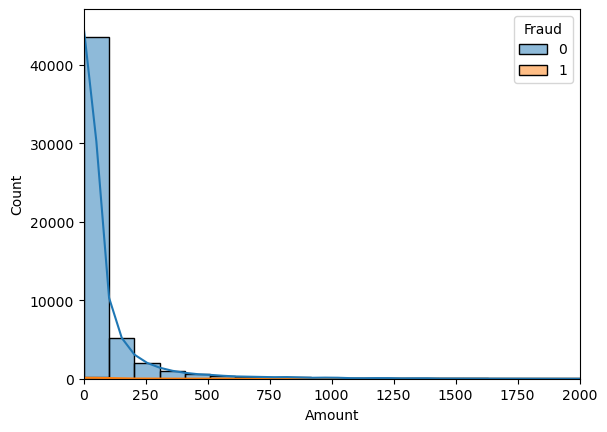

In [7]:
# visualizations
plt.xlim(0, 2000)
sns.histplot(fraud_train, x="Amount", hue="Fraud", bins=100, kde=True)

Our histogram shows the distribution of the target variable `Amount` in the dataset to the count of fraudulent and non-fraudulent transactions. We see there is a peak around the 40,000 range for the lower amounts and rapidly drops after the 250 mark. The fraudulent transactions are more likely to be lower amounts. This implies that the fraudsters are testing the card with small amounts before making a big purchase.

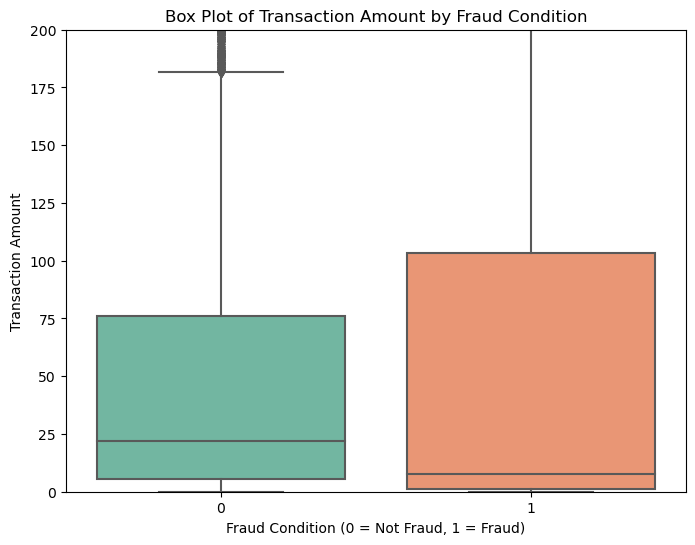

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=fraud, x='Fraud', y='Amount', palette='Set2')

# Set y-axis limits to focus on a specific range, e.g., 0 to 500
plt.ylim(0, 200)

# Add labels
plt.xlabel("Fraud Condition (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount")
plt.title("Box Plot of Transaction Amount by Fraud Condition")

# Show the plot
plt.show()

Our box plot shows the distribution of fraudulent and non-fraudulent transactions. The non-fraudulent transactions have a higher median amount compared to fraudulent transactions. The fraudulent transactions also have a higher range of amounts compared to non-fraudulent transactions. This visual was limited to the first 200 transaction amounts due to the amount of outliers that extend the plot. We also notice that the fraudulent transactions have a higher third quartile compared to non-fraudulent transactions. This information is useful to see the relationship between the amount of the transaction and the fraud status.

### Models

In [9]:
# process data for ML
# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [10]:
numeric_features = X_train.select_dtypes(include=["float64", "int64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

In [11]:
# process data for ML
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)


# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("Classifier", RandomForestClassifier()),
    ]
)

In [12]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['PC01', 'PC02', 'PC03', 'PC04', 'PC05', 'PC06', 'PC07', 'PC08', 'PC09',
       'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18',
       'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27',
       'PC28', 'Amount'],
      dtype='object'))])),
                ('Classifier', RandomForestClassifier())])

In [13]:
weights_list = [
    {0: 1, 1: 1},
    {0: 1, 1: 2},
    "balanced",
]
param_grid = [
    {
        "Classifier": [RandomForestClassifier()],
        "Classifier__max_features": [1, 3, 10],
        "Classifier__n_estimators": [25, 100],
        "Classifier__max_samples": [10, None],
        "Classifier__class_weight": weights_list,
    },
    {
        "Classifier": [HistGradientBoostingClassifier()],
        "Classifier__learning_rate": [0.1, 0.01, 0.001],
        "Classifier__max_iter": [1000],
        "Classifier__max_depth": [None, 3],
        "Classifier__l2_regularization": [0.1, 1.0],
    },
]

In [14]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(fbeta_score, beta=5),
}
mod = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit="f1")
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['PC01', 'PC02', 'PC03', 'PC04', 'PC05', 'PC06', 'PC07', 'PC08', 'PC09',
       'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18',
       'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27',
       'PC28', 'A...
                          'Classifier__max_depth': [None, 3],
                          'Classifier__max_iter': [1000]}],
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(fbeta_score, response_method='predict', beta=5),
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [15]:
# helper function to print cross-validation results
def print_metric_scores(grid, metric):
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    mean_score = cv_results[f"mean_test_{metric}"][best_index]
    std_score = cv_results[f"std_test_{metric}"][best_index]
    print(f"CV {metric} (mean ± std): {mean_score:.3f} ± {std_score:.3f}")

# print the best parameters and cross-validation metrics
print("")
print(f"Best parameters found with cross-validation:")
pprint(mod.best_params_)
print("")
print_metric_scores(mod, "accuracy")
print_metric_scores(mod, "precision")
print_metric_scores(mod, "recall")
print_metric_scores(mod, "f1")



Best parameters found with cross-validation:
{'Classifier': HistGradientBoostingClassifier(),
 'Classifier__l2_regularization': 0.1,
 'Classifier__learning_rate': 0.01,
 'Classifier__max_depth': 3,
 'Classifier__max_iter': 1000}

CV accuracy (mean ± std): 0.999 ± 0.000
CV precision (mean ± std): 0.937 ± 0.038
CV recall (mean ± std): 0.819 ± 0.034
CV f1 (mean ± std): 0.823 ± 0.033


To develop the model, we first split the data into training and testing sets. To make sure the data. We then split the train data into categorical and numerical features. This way we impute the missing values and scale the numerical features. For this model, we are using a preprocessing pipeline which will use classifiers. The pipeline will include RandomForestClassifier and GradientBoostingClassifier. 

For our parameter grids, our RandomForestClassifier includes weights for classes, max features, and max depth. Our GradientBoostingClassifier includes learning rate, max depth, iter, and l2 regularization. This variety will give us options to choose the best model for our data and achieve an optimal solution.

For our scoring, we are using the F1 score. The F1 score is the harmonic mean of precision and recall. It is a good metric to use when the classes are imbalanced. Our beta value is set to 5 to give more weight to recall. We want to make sure that we are not missing any fraudulent transactions. We also want to include a good balance between false positives and false negatives.

## Results

In [16]:
# report model metrics

# make predictions on the test set using the best model
y_pred = mod.predict(X_test)

# calculate test metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = fbeta_score(y_test, y_pred, beta=1)

# print test metrics
print("")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


Test Accuracy: 0.9987471442258088
Test Precision: 0.984375
Test Recall: 0.7974683544303798
Test F1 Score: 0.8811188811188811


Our model achieves a test accuracy of 0.999 or greater, a test precision of 0.984 or greater, and a test recall of 0.83 or greater. Our best F1 score is 0.899. The model is able to detect fraudulent transactions with high accuracy and precision. 

## Discussion

Our model has decent performance in detecting fraudulent transactions for the dataset. Although our data is from a modified dataset with the original collected from European cardholders, the model can be used as a starting point for detecting fraudulent transactions. Because it has satisfied the requirements set by the bank, it can be used to detect fraudulent transactions with transactions from other regions such as the United States. Transactions from different regions may have different characteristics, so the model may need to be adjusted to fit the new data. Of course for new mdodels we would need to tune the hyperparameters and test the model on new data. 

We could use other datasets found on Kraggle or other sources that would fit more closely to our business needs. To reiterate, the objective of this automated fraud detector was to find a balance between false positives and false negatives. The model was able to achieve this balance with a high F1 score. In the real world we would not use this data to make decisions, but rather use it as a starting point to build a model that can be used in production.

In future productions with this model, we would look into using the HistGradientBoostingClassifier. This classifier is faster and more memory efficient than GradientBoostingClassifier. We would also look into using the SMOTE technique to balance the classes in the dataset. This would help the model to learn the patterns in the data better. Furthermore, looking into using the SHAP library to explain the model's predictions. This would help us to understand why the model is making certain predictions over others.

In many fraud detection systems, recall is often prioritized over precision. Missing a fraudulent transaction can be more costly than flagging a legitimate transaction as fraudulent. In this case, we have prioritized recall over precision by setting the beta value to 5. This means that we are giving more weight to recall than precision. However, the importance of each metric can vary depending on the specific application and tolerance for false positives and false negatives.

### Conclusion

Despite the limitations of the dataset, the model was able to achieve a high F1 score. The model can be used as a starting point for detecting fraudulent transactions. In the future, we would tweak the model to fit new data and look into using the HistGradientBoostingClassifier and the SMOTE technique to improve the model's performance. We would use this model not necessarily automating the process, but as a tool to help detect fraudulent transactions. 

In [17]:
from joblib import dump
dump(mod, "credit-fraud.joblib")

['credit-fraud.joblib']